<a href="https://colab.research.google.com/github/alexrofail/ImgClass-WithFastAI/blob/main/matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [ ]:
a = torch.tensor([1,0])

In [ ]:
a

tensor([1, 0])

In [ ]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
img = x_train[0]

In [ ]:
img.view(28,28).type()

'torch.FloatTensor'

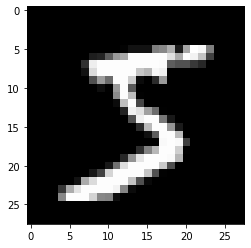

In [ ]:
plt.imshow(img.view((28,28)))

In [ ]:
#linear model y = ax +b 
weights = torch.randn(784,10)

In [ ]:
bias = torch.zeros(10)

In [ ]:
#Now we need to do matrix multiplacation (affine functions)
def matmul(a,b):
  #rows and columns of a
  ar, ac = a.shape
  br, bc = b.shape
  assert ac == br
  c = torch.zeros(ar, bc)

  #three loops representing matrix multiplication
  for i in range (ar):
    for j in range(bc):
      for k in range (ac):  #or b's rows br
        c[i,j] += a[i,k] * b[k,j]
  return c 

In [ ]:
m1 = x_valid[:5]
m2 = weights

In [ ]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
%time t1=matmul(m1,m2)

CPU times: user 584 ms, sys: 6.64 ms, total: 591 ms
Wall time: 607 ms


In [ ]:
t1.shape

torch.Size([5, 10])

In [ ]:
#to make this a lot faster we have to pass the computation from python to something like PyTorch (using a10 library)


In [ ]:
#We want to use element wise ops, like examples below

a = tensor([10,4,11])
b = tensor([22,12,3])
a,b

(tensor([10,  4, 11]), tensor([22, 12,  3]))

In [ ]:
a+b

tensor([32, 16, 14])

In [ ]:
(a<b).float().mean()

tensor(0.6667)

In [ ]:
m = tensor([[1,2,3], [4,5,6], [7,8,9]]); m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
#Frobenius Norm
(m*m).sum().sqrt()

tensor(16.8819)

In [ ]:
#Refactor matmul to have two loops not three
def matmul(a,b):
  def matmul(a,b):
    #rows and columns of a
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)

    #two loops now
    for i in range(ar):
      for j in range(bc):
        c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [ ]:
#broadcasting

In [ ]:
c = tensor([10,20,30])

In [ ]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m+c

tensor([[11, 22, 33],
        [14, 25, 36],
        [17, 28, 39]])

In [ ]:
t = c.expand_as(m)

In [ ]:
t

tensor([[10, 20, 30],
        [10, 20, 30],
        [10, 20, 30]])

In [ ]:
t.storage()

 10
 20
 30
[torch.LongStorage of size 3]

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [ ]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [ ]:
c.shape, c[None,:].shape, c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [ ]:
c[:,None].expand_as(m)

tensor([[10, 10, 10],
        [20, 20, 20],
        [30, 30, 30]])

In [ ]:
m + c[:,None]

tensor([[11, 12, 13],
        [24, 25, 26],
        [37, 38, 39]])

In [ ]:
#Matrix Multiply with Broadcasting
def matmul(a,b):
  #rows and columns of a
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
      c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0) # or you can write a[i,None] *b ... instead of unsqueeze

    return c

In [ ]:
#Einstein Summation

def matmul(a,b): return torch.einsum('ik,kj -> ij', a,b)

In [ ]:
%timeit -n 10 _=matmul(m1,m2)

The slowest run took 83.69 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 22.5 µs per loop


In [ ]:
#Even faster than einsum is PyTorch Op, matmul as a method basically
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 5.69 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 8.37 µs per loop


In [ ]:
#Forward and Backward passing, now we are doing NNs

def normalize(x,m,s): return (x-m)/s

In [ ]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [ ]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(3.8966e-08), tensor(1.))

In [ ]:
def test_near_zero(a, tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [ ]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [ ]:
n, m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [ ]:
#Basic Architecture
nh = 50

In [ ]:
#Weights and Biases matrices
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [ ]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [ ]:
x_valid.mean(), x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [ ]:
def lin(x, w, b): return x@w + b 

In [ ]:
t = lin(x_valid, w1, b1)
t.mean(), t.std()

(tensor(0.0365), tensor(1.0008))

In [70]:
#First layer will not just be a regular linear function, it will be a ReLu
#The clamp function here just takes all neg. values and makes 0
def relu(x): return x.clamp_min(0.)

In [ ]:
t = relu(lin(x_valid, w1,b1))
t.mean(), t.std()

(tensor(0.4163), tensor(0.6069))

In [78]:
#kaiming initializing
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [79]:
w1.mean(), w1.std()

(tensor(-0.0004), tensor(0.0503))

In [ ]:
from torch.nn import init

In [ ]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))

In [ ]:
init.kaiming_normal_??

In [ ]:
w1.mean(), w1.std()

(tensor(-0.0002), tensor(0.0501))

In [ ]:
t.mean(), t.std()

(tensor(0.6534), tensor(0.9072))

In [ ]:
w1.shape

torch.Size([784, 50])

In [ ]:
import torch.nn

In [ ]:
torch.nn.Linear(m,nh).weight.shape

torch.Size([50, 784])

In [ ]:
torch.nn.Linear.forward??

In [ ]:
torch.nn.functional.linear??

In [ ]:
torch.nn.Conv2d??

In [ ]:
torch.nn.modules.conv._ConvNd.reset_parameters??

In [80]:
#experiment
def relu(x): return x.clamp_min(0.) - 0.5

In [81]:
w1 = torch.randn(m,nh)*math.sqrt(2./m)
t1 = relu(lin(x_valid, w1, b1))

In [82]:
t1.mean(), t1.std()

(tensor(0.0272), tensor(0.8248))

In [83]:
#super ultra mega basic model
def model(xb):
  layer1 = lin(xb, w1,b1)
  activation1 = relu(layer1)
  layer3 = lin(layer2, w2,b2)
  return layer3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')